In [76]:
import pandas as pd
import glob
import numpy as np
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

In [77]:
#ファイル読み込み
df = pd.DataFrame()
for i in glob.glob("train/*.csv*"):
    tmp_df=pd.read_csv(i)
    df = pd.concat([df, tmp_df],ignore_index=True)

C:\Users\osako\AppData\Local\Temp\ipykernel_16128\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_16128\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_16128\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)
C:\Users\osako\AppData\Local\Temp\ipykernel_16128\132664144.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df=pd.read_csv(i)


In [78]:
#欠損値確認,欠損値削除
df_rownum=df.shape[0]
df_null_column=df.columns[df.isnull().sum()==df_rownum]
df=df.drop(df_null_column,axis=1)

In [79]:
df.drop(['ID',
         '種類',
#                '地区名',
#                '最寄駅：名称',
        '市区町村コード',
#                '用途',
#                '市区町村名',
#                '間取り',
#                '建物の構造',
#                '都市計画'
              ],inplace=True,axis=1)
df["取引の事情等"].fillna(0, inplace=True)
df.loc[df["取引の事情等"] != 0, "取引の事情等"] = 1

In [80]:
#欠損値の多い列を削除
df=df.drop(['今後の利用目的'],axis=1)

In [81]:
#各列のユニークな値を抽出
unique_value=df.apply(pd.Series.unique)
# print(unique_value['都道府県名'])

In [82]:
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)

In [83]:
df_edit1=df.copy()
df_edit1.dropna(inplace=True)
df_edit1.reset_index(drop=True, inplace=True)

In [84]:
df_edit1

,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,東京都,板橋区,中台,志村三丁目,12,３ＬＤＫ,70,昭和53年,ＳＲＣ,住宅,第１種中高層住居専用地域,60.0,200.0,2005年第3四半期,改装済,0,7.342423
1,東京都,文京区,小石川,後楽園,11,１Ｋ,20,平成17年,ＲＣ,住宅,商業地域,80.0,600.0,2005年第3四半期,未改装,0,7.301030
2,東京都,足立区,千住寿町,北千住,8,１Ｒ,20,昭和64年,ＳＲＣ,住宅,商業地域,80.0,600.0,2005年第3四半期,未改装,0,6.857332
3,東京都,杉並区,南荻窪,荻窪,14,１Ｋ,20,平成10年,ＲＣ,住宅,近隣商業地域,80.0,300.0,2005年第3四半期,未改装,0,7.176091
4,埼玉県,さいたま市浦和区,元町,北浦和,10,３ＬＤＫ,60,昭和59年,ＲＣ,住宅,第２種中高層住居専用地域,60.0,200.0,2005年第3四半期,改装済,0,7.204120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564688,大阪府,吹田市,青山台,北千里,18,４ＬＤＫ,85,令和3年,ＲＣ,住宅,第１種中高層住居専用地域,60.0,200.0,2022年第1四半期,未改装,0,7.740363
564689,静岡県,浜松市北区,三ヶ日町都筑,都筑,25,１Ｋ,25,昭和49年,ＳＲＣ,住宅,市街化調整区域,60.0,200.0,2022年第1四半期,未改装,0,4.698970
564690,東京都,世田谷区,若林,若林(東京),2,１Ｋ,25,平成23年,ＲＣ,住宅,近隣商業地域,80.0,300.0,2022年第1四半期,未改装,0,7.447158
564691,静岡県,沼津市,杉崎町,沼津,13,２ＬＤＫ,55,昭和57年,ＲＣ,住宅,第２種住居地域,60.0,200.0,2022年第1四半期,改装済,0,6.477121


In [85]:
val_min_idx = min(df_edit1[df_edit1['取引時点'].str.contains('2021年第4四半期|2022年第1四半期', regex=True)].index)
# test_min_idx = min(df[df['取引時点'].str.contains('2022年第2四半期|2022年第3四半期', regex=True)].index)
val_min_idx
# test_min_idx

547549

In [86]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df_edit1['取引時点_enc'] = df_edit1['取引時点'].map(enc_dic)

In [87]:
TARGET = '取引価格（総額）_log'
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df_edit1[time_col].values):
    #'取引時点_encがiより小さい行だけ取り出されている
    #各年の四半期までの平均ではなく、その時点までの平均を計算しています。
    tmp_df = df_edit1[df_edit1[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

In [88]:
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '都道府県名'
def calc_te(row):
    #辞書の中のdfの'取引時点_enc'かつ四半期の都道府県
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df_edit1[group_col+'_te'] = df_edit1.apply(calc_te, axis=1)
df_edit1.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
0,東京都,板橋区,中台,志村三丁目,12,３ＬＤＫ,70,昭和53年,ＳＲＣ,住宅,第１種中高層住居専用地域,60.0,200.0,2005年第3四半期,改装済,0,7.342423,0,0.0
1,東京都,文京区,小石川,後楽園,11,１Ｋ,20,平成17年,ＲＣ,住宅,商業地域,80.0,600.0,2005年第3四半期,未改装,0,7.301030,0,0.0


In [89]:
df_edit1.loc[df_edit1['建築年']=='戦前','建築年']='昭和20年'
df_edit1['和暦名称']=df_edit1['建築年'].str[:2]
df_edit1['西暦']=df_edit1['建築年'].str[2:-1]
df_edit1['西暦'].unique()
df_edit1['西暦']=df_edit1['西暦'].astype(float)
# print(df_edit1['西暦'].unique())
df_edit1.loc[df_edit1['和暦名称']=='昭和','西暦']+=1925
df_edit1.loc[df_edit1['和暦名称']=='平成','西暦']+=1988
df_edit1.loc[df_edit1['和暦名称']=='令和','西暦']+=2018
# print(df_edit1)
df_edit1.drop(['和暦名称','建築年'],inplace=True,axis=1)
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='30分?60分','最寄駅：距離（分）']=45
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='1H?1H30','最寄駅：距離（分）']=75
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='1H30?2H','最寄駅：距離（分）']=105
df_edit1.loc[df_edit1['最寄駅：距離（分）']=='2H?','最寄駅：距離（分）']=120
df_edit1['取引時点年数']=df_edit1['取引時点'].str[:4]
df_edit1['四半期']=df_edit1['取引時点'].str[5:]
df_edit1.loc[df_edit1['四半期']=='第2四半期','取引時点年数']+='.25'
df_edit1.loc[df_edit1['四半期']=='第3四半期','取引時点年数']+='.5'
df_edit1.loc[df_edit1['四半期']=='第4四半期','取引時点年数']+='.75'
df_edit1.drop(['取引時点'],
#                '四半期'],
              inplace=True,axis=1)

In [90]:
df_edit1.loc[df_edit1['面積（㎡）']=='2000㎡以上','面積（㎡）']='2000'

In [91]:
df_edit1['最寄駅：距離（分）']=df_edit1['最寄駅：距離（分）'].astype(float)
df_edit1['面積（㎡）']=df_edit1['面積（㎡）'].astype(int)
df_edit1['西暦']=df_edit1['西暦'].astype(float)
df_edit1['取引時点年数']=df_edit1['取引時点年数'].astype(float)
df_edit1['容積率（％）']=df_edit1['容積率（％）'].astype(float)
df_edit1['建ぺい率（％）']=df_edit1['建ぺい率（％）'].astype(float)
df_edit1['取引価格（総額）_log']=df_edit1['取引価格（総額）_log'].astype(float)

In [92]:
df_test=df_edit1['取引価格（総額）_log']
df_edit1.drop('取引価格（総額）_log',inplace=True,axis=1)

In [93]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df_edit1, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,7419,7419,7419,7419,7.440221,47.131015,66.953767,297.484836,0.0,10,40.0,80.0,120.0,155,80.0,800.0
1,5891,5891,5891,5891,5.372433,41.398744,74.041759,462.705822,0.0,10,60.0,100.0,20.0,1300,80.0,600.0


In [94]:
df_edit1=pd.concat([df_edit1]+agg_dfs, 
          axis=1)
# print(feat_df.shape)

In [95]:
df_dummy

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引の事情等,取引時点_enc,都道府県名_te,西暦,取引時点年数,agg_count_最寄駅：距離（分）_grpby_市区町村名,...,4,5,6,7,8,9,建ぺい率×容積率,敷地面積,延べ床面積,年差
0,2.484907,4.248495,60.0,200.0,0.0,0,0.000000,1978.0,2005.5,7419,...,7.0,847.0,6.0,7.0,2.0,0.0,12000.0,7.080825,14.161651,-27.5
1,2.397895,2.995732,80.0,600.0,0.0,0,0.000000,2005.0,2005.5,5891,...,4.0,4830.0,6.0,0.0,2.0,1.0,48000.0,3.744665,22.467992,-0.5
2,2.079442,2.995732,80.0,600.0,0.0,0,0.000000,1989.0,2005.5,6167,...,7.0,2402.0,6.0,0.0,2.0,1.0,48000.0,3.744665,22.467992,-16.5
3,2.639057,2.995732,80.0,300.0,0.0,0,0.000000,1998.0,2005.5,6875,...,4.0,2723.0,6.0,13.0,2.0,1.0,24000.0,3.744665,11.233996,-7.5
4,2.302585,4.094345,60.0,200.0,0.0,0,0.000000,1984.0,2005.5,1318,...,4.0,1633.0,6.0,10.0,2.0,0.0,12000.0,6.823908,13.647815,-21.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564688,2.890372,4.442651,60.0,200.0,0.0,66,7.191460,2021.0,2022.0,4359,...,4.0,11355.0,6.0,7.0,0.0,1.0,12000.0,7.404419,14.808838,-1.0
564689,3.218876,3.218876,60.0,200.0,0.0,66,7.024255,1974.0,2022.0,290,...,7.0,237.0,6.0,4.0,0.0,1.0,12000.0,5.364793,10.729586,-48.0
564690,0.693147,3.218876,80.0,300.0,0.0,66,7.409909,2011.0,2022.0,9650,...,4.0,9693.0,6.0,13.0,0.0,1.0,24000.0,4.023595,12.070784,-11.0
564691,2.564949,4.007333,60.0,200.0,0.0,66,7.024255,1982.0,2022.0,522,...,4.0,6506.0,6.0,12.0,0.0,0.0,12000.0,6.678889,13.357777,-40.0


In [96]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

labels = df_edit1[[
#     '市区町村コード',
    '都道府県名',
    '市区町村名',
    '最寄駅：名称',
     '間取り',
     '建物の構造',
    '地区名',
     '用途',
    '都市計画',
    '四半期',
    '改装']].values
labels_id = oe.fit_transform(labels)
# df_dummy = pd.concat([df_edit1, labels_id], axis=1)
# df_dummy.drop(['都道府県名', 
#                '市区町村名',
#                '間取り',
#                 '建物の構造',
#                 '都市計画',
#                '改装'],axis=1,inplace=True)
df_dummy = pd.concat([df_edit1.reset_index(drop=True), pd.DataFrame(labels_id)], axis=1)
df_dummy.drop(['都道府県名',
               '市区町村名', 
               '四半期',
               '間取り', 
               '建物の構造', 
               '都市計画',
               '最寄駅：名称',
               '地区名',
               '用途',
               '改装'], axis=1, inplace=True)
print(labels_id.shape) 

(564693, 10)


In [97]:
df_dummy['面積（㎡）']=np.log(df_dummy['面積（㎡）'])
df_dummy['面積（㎡）'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_dummy['面積（㎡）'].fillna(0,inplace=True)

In [98]:
df_dummy['最寄駅：距離（分）']=np.log(df_dummy['最寄駅：距離（分）'])
df_dummy['最寄駅：距離（分）'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_dummy['最寄駅：距離（分）'].fillna(0,inplace=True)

c:\users\osako\pycharmprojects\pythonproject2\venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [99]:
df_dummy['建ぺい率×容積率']=df_dummy['建ぺい率（％）']*df_dummy['容積率（％）']
df_dummy['敷地面積']=df_dummy['面積（㎡）']/df_dummy['建ぺい率（％）']*100
df_dummy['延べ床面積']=df_dummy['容積率（％）']/100*df_dummy['敷地面積']
df_dummy['年差']=df_dummy['西暦']-df_dummy['取引時点年数']
df_dummy.isnull().sum()

最寄駅：距離（分）                          0
面積（㎡）                              0
建ぺい率（％）                            0
容積率（％）                             0
取引の事情等                             0
取引時点_enc                           0
都道府県名_te                           0
西暦                                 0
取引時点年数                             0
agg_count_最寄駅：距離（分）_grpby_市区町村名    0
agg_count_面積（㎡）_grpby_市区町村名        0
agg_count_建ぺい率（％）_grpby_市区町村名      0
agg_count_容積率（％）_grpby_市区町村名       0
agg_mean_最寄駅：距離（分）_grpby_市区町村名     0
agg_mean_面積（㎡）_grpby_市区町村名         0
agg_mean_建ぺい率（％）_grpby_市区町村名       0
agg_mean_容積率（％）_grpby_市区町村名        0
agg_min_最寄駅：距離（分）_grpby_市区町村名      0
agg_min_面積（㎡）_grpby_市区町村名          0
agg_min_建ぺい率（％）_grpby_市区町村名        0
agg_min_容積率（％）_grpby_市区町村名         0
agg_max_最寄駅：距離（分）_grpby_市区町村名      0
agg_max_面積（㎡）_grpby_市区町村名          0
agg_max_建ぺい率（％）_grpby_市区町村名        0
agg_max_容積率（％）_grpby_市区町村名         0
0                                  0
1                                  0
2

In [100]:
df_dummy

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引の事情等,取引時点_enc,都道府県名_te,西暦,取引時点年数,agg_count_最寄駅：距離（分）_grpby_市区町村名,...,4,5,6,7,8,9,建ぺい率×容積率,敷地面積,延べ床面積,年差
0,2.484907,4.248495,60.0,200.0,0,0,0.000000,1978.0,2005.5,7419,...,7.0,847.0,6.0,7.0,2.0,0.0,12000.0,7.080825,14.161651,-27.5
1,2.397895,2.995732,80.0,600.0,0,0,0.000000,2005.0,2005.5,5891,...,4.0,4830.0,6.0,0.0,2.0,1.0,48000.0,3.744665,22.467992,-0.5
2,2.079442,2.995732,80.0,600.0,0,0,0.000000,1989.0,2005.5,6167,...,7.0,2402.0,6.0,0.0,2.0,1.0,48000.0,3.744665,22.467992,-16.5
3,2.639057,2.995732,80.0,300.0,0,0,0.000000,1998.0,2005.5,6875,...,4.0,2723.0,6.0,13.0,2.0,1.0,24000.0,3.744665,11.233996,-7.5
4,2.302585,4.094345,60.0,200.0,0,0,0.000000,1984.0,2005.5,1318,...,4.0,1633.0,6.0,10.0,2.0,0.0,12000.0,6.823908,13.647815,-21.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564688,2.890372,4.442651,60.0,200.0,0,66,7.191460,2021.0,2022.0,4359,...,4.0,11355.0,6.0,7.0,0.0,1.0,12000.0,7.404419,14.808838,-1.0
564689,3.218876,3.218876,60.0,200.0,0,66,7.024255,1974.0,2022.0,290,...,7.0,237.0,6.0,4.0,0.0,1.0,12000.0,5.364793,10.729586,-48.0
564690,0.693147,3.218876,80.0,300.0,0,66,7.409909,2011.0,2022.0,9650,...,4.0,9693.0,6.0,13.0,0.0,1.0,24000.0,4.023595,12.070784,-11.0
564691,2.564949,4.007333,60.0,200.0,0,66,7.024255,1982.0,2022.0,522,...,4.0,6506.0,6.0,12.0,0.0,0.0,12000.0,6.678889,13.357777,-40.0


In [101]:
df_dummy['取引の事情等']=df_dummy['取引の事情等'].astype(float)

In [102]:
df_dummy.columns = df_dummy.columns.astype(str)

In [103]:
df_dummy

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引の事情等,取引時点_enc,都道府県名_te,西暦,取引時点年数,agg_count_最寄駅：距離（分）_grpby_市区町村名,...,4,5,6,7,8,9,建ぺい率×容積率,敷地面積,延べ床面積,年差
0,2.484907,4.248495,60.0,200.0,0.0,0,0.000000,1978.0,2005.5,7419,...,7.0,847.0,6.0,7.0,2.0,0.0,12000.0,7.080825,14.161651,-27.5
1,2.397895,2.995732,80.0,600.0,0.0,0,0.000000,2005.0,2005.5,5891,...,4.0,4830.0,6.0,0.0,2.0,1.0,48000.0,3.744665,22.467992,-0.5
2,2.079442,2.995732,80.0,600.0,0.0,0,0.000000,1989.0,2005.5,6167,...,7.0,2402.0,6.0,0.0,2.0,1.0,48000.0,3.744665,22.467992,-16.5
3,2.639057,2.995732,80.0,300.0,0.0,0,0.000000,1998.0,2005.5,6875,...,4.0,2723.0,6.0,13.0,2.0,1.0,24000.0,3.744665,11.233996,-7.5
4,2.302585,4.094345,60.0,200.0,0.0,0,0.000000,1984.0,2005.5,1318,...,4.0,1633.0,6.0,10.0,2.0,0.0,12000.0,6.823908,13.647815,-21.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564688,2.890372,4.442651,60.0,200.0,0.0,66,7.191460,2021.0,2022.0,4359,...,4.0,11355.0,6.0,7.0,0.0,1.0,12000.0,7.404419,14.808838,-1.0
564689,3.218876,3.218876,60.0,200.0,0.0,66,7.024255,1974.0,2022.0,290,...,7.0,237.0,6.0,4.0,0.0,1.0,12000.0,5.364793,10.729586,-48.0
564690,0.693147,3.218876,80.0,300.0,0.0,66,7.409909,2011.0,2022.0,9650,...,4.0,9693.0,6.0,13.0,0.0,1.0,24000.0,4.023595,12.070784,-11.0
564691,2.564949,4.007333,60.0,200.0,0.0,66,7.024255,1982.0,2022.0,522,...,4.0,6506.0,6.0,12.0,0.0,0.0,12000.0,6.678889,13.357777,-40.0


In [104]:
X_train=df_dummy.iloc[:val_min_idx,:]
y_train=df_test.iloc[:val_min_idx]
X_test=df_dummy.iloc[val_min_idx:,:]
y_test=df_test.iloc[val_min_idx:]

In [105]:
X_train

,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引の事情等,取引時点_enc,都道府県名_te,西暦,取引時点年数,agg_count_最寄駅：距離（分）_grpby_市区町村名,...,4,5,6,7,8,9,建ぺい率×容積率,敷地面積,延べ床面積,年差
0,2.484907,4.248495,60.0,200.0,0.0,0,0.000000,1978.0,2005.5,7419,...,7.0,847.0,6.0,7.0,2.0,0.0,12000.0,7.080825,14.161651,-27.5
1,2.397895,2.995732,80.0,600.0,0.0,0,0.000000,2005.0,2005.5,5891,...,4.0,4830.0,6.0,0.0,2.0,1.0,48000.0,3.744665,22.467992,-0.5
2,2.079442,2.995732,80.0,600.0,0.0,0,0.000000,1989.0,2005.5,6167,...,7.0,2402.0,6.0,0.0,2.0,1.0,48000.0,3.744665,22.467992,-16.5
3,2.639057,2.995732,80.0,300.0,0.0,0,0.000000,1998.0,2005.5,6875,...,4.0,2723.0,6.0,13.0,2.0,1.0,24000.0,3.744665,11.233996,-7.5
4,2.302585,4.094345,60.0,200.0,0.0,0,0.000000,1984.0,2005.5,1318,...,4.0,1633.0,6.0,10.0,2.0,0.0,12000.0,6.823908,13.647815,-21.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547544,1.098612,4.317488,60.0,150.0,0.0,64,7.274751,1998.0,2021.5,1561,...,4.0,11192.0,6.0,7.0,2.0,1.0,9000.0,7.195814,10.793720,-23.5
547545,3.332205,4.007333,60.0,200.0,0.0,64,7.274751,1971.0,2021.5,2627,...,4.0,8923.0,6.0,7.0,2.0,1.0,12000.0,6.678889,13.357777,-50.5
547546,1.098612,4.442651,60.0,300.0,0.0,64,7.187452,2009.0,2021.5,763,...,4.0,1021.0,6.0,6.0,2.0,1.0,18000.0,7.404419,22.213256,-12.5
547547,3.806662,4.174387,60.0,200.0,0.0,64,7.406143,1998.0,2021.5,4051,...,4.0,6266.0,6.0,7.0,2.0,1.0,12000.0,6.957312,13.914624,-23.5


In [117]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb_r = xgb.XGBRegressor(objective='reg:linear',
                         learning_rate=0.3,
                         reg_lambda=1,
                         n_estimators=400,
                         early_stopping_rounds=20,
                         max_depth=8,
                         seed=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost model with early stopping
xgb_r.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=True)

y_pred_train = xgb_r.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
print("Train RMSE:", rmse_train)

y_pred_test = xgb_r.predict(scaler.transform(X_test))
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)

[00:57:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.81433
[1]	validation_0-rmse:3.38613
[2]	validation_0-rmse:2.38496
[3]	validation_0-rmse:1.68666
[4]	validation_0-rmse:1.19782
[5]	validation_0-rmse:0.85664
[6]	validation_0-rmse:0.62048
[7]	validation_0-rmse:0.45814
[8]	validation_0-rmse:0.34648
[9]	validation_0-rmse:0.27287
[10]	validation_0-rmse:0.22520
[11]	validation_0-rmse:0.19580
[12]	validation_0-rmse:0.17691
[13]	validation_0-rmse:0.16495
[14]	validation_0-rmse:0.15720
[15]	validation_0-rmse:0.15267
[16]	validation_0-rmse:0.14909
[17]	validation_0-rmse:0.14701
[18]	validation_0-rmse:0.14556
[19]	validation_0-rmse:0.14454
[20]	validation_0-rmse:0.14362
[21]	validation_0-rmse:0.14238
[22]	validation_0-rmse:0.14196
[23]	validation_0-rmse:0.14108
[24]	validation_0-rmse:0.14065
[25]

In [109]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

xgb_r = xgb.XGBRegressor(objective='reg:linear',
                         learning_rate=0.3, 
                         reg_lambda=1,
                         n_estimators=400,
                         max_depth=8,
                         seed=123)
xgb_r.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)],
         early_stopping_rounds=20)

c:\users\osako\pycharmprojects\pythonproject2\venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[00:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.81433
[1]	validation_0-rmse:3.38613
[2]	validation_0-rmse:2.38496
[3]	validation_0-rmse:1.68666
[4]	validation_0-rmse:1.19782
[5]	validation_0-rmse:0.85664
[6]	validation_0-rmse:0.62048
[7]	validation_0-rmse:0.45814
[8]	validation_0-rmse:0.34648
[9]	validation_0-rmse:0.27287
[10]	validation_0-rmse:0.22520
[11]	validation_0-rmse:0.19580
[12]	validation_0-rmse:0.17691
[13]	validation_0-rmse:0.16495
[14]	validation_0-rmse:0.15720
[15]	validation_0-rmse:0.15267
[16]	validation_0-rmse:0.14909
[17]	validation_0-rmse:0.14701
[18]	validation_0-rmse:0.14556
[19]	validation_0-rmse:0.14454
[20]	validation_0-rmse:0.14362
[21]	validation_0-rmse:0.14238
[22]	validation_0-rmse:0.14196
[23]	validation_0-rmse:0.14108
[24]	validation_0-rmse:0.14065
[25]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [ ]:
# K分割交差検証
from sklearn.model_selection import KFold
 sklearn.model_selection import KFold
# データの分割
kf = KFold(n_splits=5, shuffle=True, random_state=42)
valid_mse = []
i = 1
for train_id, test_id in kf.split(X_set):
   # モデルの学習
    pipe.fit(X_train, y_train)
    # テストデータの予測値とMSEの計算
    y_pred_test = pipe.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    # テストデータでのRMSE
    print('{}Fold テストRMSE: {}'.format(i, np.sqrt(test_mse)))  # 各Kの誤差を表示
    valid_mse.append(np.sqrt(test_mse))  # 各KのテストMSEの平均が検証誤差
    i += 1

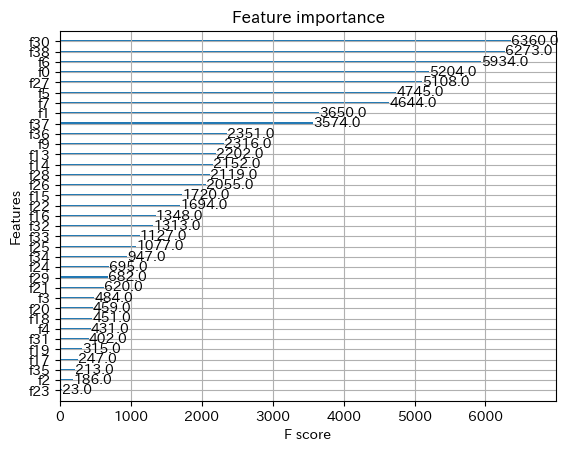

In [64]:
import matplotlib.pyplot as plt
import japanize_matplotlib
xgb.plot_importance(xgb_r)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [64]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=300,
                              n_jobs=None, num_paralle

In [60]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error
from itertools import product

# Define the hyperparameter combinations
param_grid = {
    'learning_rate': [0.3, 0.6, 1],
    'max_depth': [6, 8, 11],
    'reg_lambda': [0.5, 1],
    'n_estimators': [300],
    'subsample': [0.6, 1],
    'colsample_bytree': [0.6, 1],
#     'min_child_weight': [1, 5]
}


# Initialize the best model, best parameters, and best accuracy
best_model = None
best_params = None
best_mae = float('inf') 

# Hyperparameter tuning and model evaluation
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    print(param_dict)
    # Create a pipeline with feature scaling and XGBoost classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', xgb.XGBRegressor(**param_dict))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    if mae < best_mae:
        best_mae = mae
        best_model = pipeline
        best_params = params

# Retrain the best model with the entire training set
# best_model.fit(X_train, y_train)

# # Evaluate the final model on the test set
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)


{'learning_rate': 0.3, 'max_depth': 6, 'reg_lambda': 0.5, 'n_estimators': 300, 'subsample': 0.6, 'colsample_bytree': 0.6}
{'learning_rate': 0.3, 'max_depth': 6, 'reg_lambda': 0.5, 'n_estimators': 300, 'subsample': 0.6, 'colsample_bytree': 1}
{'learning_rate': 0.3, 'max_depth': 6, 'reg_lambda': 0.5, 'n_estimators': 300, 'subsample': 1, 'colsample_bytree': 0.6}
{'learning_rate': 0.3, 'max_depth': 6, 'reg_lambda': 0.5, 'n_estimators': 300, 'subsample': 1, 'colsample_bytree': 1}
{'learning_rate': 0.3, 'max_depth': 6, 'reg_lambda': 1, 'n_estimators': 300, 'subsample': 0.6, 'colsample_bytree': 0.6}
{'learning_rate': 0.3, 'max_depth': 6, 'reg_lambda': 1, 'n_estimators': 300, 'subsample': 0.6, 'colsample_bytree': 1}
{'learning_rate': 0.3, 'max_depth': 6, 'reg_lambda': 1, 'n_estimators': 300, 'subsample': 1, 'colsample_bytree': 0.6}
{'learning_rate': 0.3, 'max_depth': 6, 'reg_lambda': 1, 'n_estimators': 300, 'subsample': 1, 'colsample_bytree': 1}
{'learning_rate': 0.3, 'max_depth': 8, 'reg_lamb

{'learning_rate': 1, 'max_depth': 11, 'reg_lambda': 1, 'n_estimators': 300, 'subsample': 0.6, 'colsample_bytree': 1}
{'learning_rate': 1, 'max_depth': 11, 'reg_lambda': 1, 'n_estimators': 300, 'subsample': 1, 'colsample_bytree': 0.6}
{'learning_rate': 1, 'max_depth': 11, 'reg_lambda': 1, 'n_estimators': 300, 'subsample': 1, 'colsample_bytree': 1}


In [37]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter combinations
param_grid = {
    'model__learning_rate': [0.3, 0.6, 1],
    'model__max_depth': [3, 6, 9, 11],
    'model__reg_lambda': [0.5, 1],
    'model__n_estimators': [200, 400, 600],
    'model__subsample': [0.5, 0.75, 1],
    'model__colsample_bytree': [0.5, 0.75, 1],
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0, 0.1, 0.5, 1, 3]
}

# Create a pipeline with feature scaling and XGBoost regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor())
])

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model, best parameters, and best MAE
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
# y_pred = best_model.predict(X_test)
# best_mae = mean_absolute_error(y_val, y_pred)


KeyboardInterrupt: 

In [35]:
xgb_r.feature_names_in_(xgb_r)

AttributeError: `feature_names_in_` is defined only when `X` has feature names that are all strings.

AttributeError: 'XGBRegressor' object has no attribute 'get_fscore'